Import Libraries and Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("-"*60)

# Load the training data (same as before)
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f'sensor_{i}' for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('../data/train_FD001.txt', 
                       sep=' ', 
                       header=None, 
                       names=column_names,
                       index_col=False)

train_df = train_df.dropna(axis=1, how='all')

# Calculate RUL (from previous notebook)
max_cycles = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_cycles']

print(f"Data loaded: {train_df.shape}")
print(f"Columns: {train_df.shape[1]}")
print("\nFirst few rows:")
train_df.head(3)

Libraries imported successfully!
------------------------------------------------------------
Data loaded: (20631, 28)
Columns: 28

First few rows:


,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycles,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189


Remove Low-Variance Sensors

In [2]:
# Remove low-variance sensors identified in exploration
low_variance_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 
                        'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

print("-"*60)
print("REMOVING LOW-VARIANCE SENSORS")
print("-"*60)
print(f"\nSensors to remove: {low_variance_sensors}")
print(f"Original shape: {train_df.shape}")

# Drop these sensors
train_df = train_df.drop(columns=low_variance_sensors)

print(f"New shape: {train_df.shape}")
print(f"Removed {len(low_variance_sensors)} sensors")

print("\n" + "-"*60)
print("REMAINING COLUMNS")
print("-"*60)
print(train_df.columns.tolist())

------------------------------------------------------------
REMOVING LOW-VARIANCE SENSORS
------------------------------------------------------------

Sensors to remove: ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Original shape: (20631, 28)
New shape: (20631, 21)
Removed 7 sensors

------------------------------------------------------------
REMAINING COLUMNS
------------------------------------------------------------
['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'max_cycles', 'RUL']


Normalize Sensor Values (Feature Scaling)

In [4]:
# Identify sensor and setting columns to scale
sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
setting_cols = ['setting_1', 'setting_2', 'setting_3']
features_to_scale = sensor_cols + setting_cols

print("-"*60)
print("FEATURE SCALING (NORMALIZATION)")
print("-"*60)
print(f"\nFeatures to scale: {len(features_to_scale)}")
print(features_to_scale)

# Check ranges before scaling
print("\n" + "-"*60)
print("BEFORE SCALING - Sample ranges:")
print("-"*60)
for col in features_to_scale[:5]:  # Show first 5
    print(f"{col}: {train_df[col].min():.2f} to {train_df[col].max():.2f}")

# Initialize MinMaxScaler (scales to 0-1 range)
scaler = MinMaxScaler()

# Fit and transform the features
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

# Check ranges after scaling
print("\n" + "-"*60)
print("AFTER SCALING - All features now 0 to 1:")
print("-"*60)
for col in features_to_scale[:5]:  # Show first 5
    print(f"{col}: {train_df[col].min():.2f} to {train_df[col].max():.2f}")

print("\n All sensor and setting values normalized to [0, 1] range")

------------------------------------------------------------
FEATURE SCALING (NORMALIZATION)
------------------------------------------------------------

Features to scale: 17
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'setting_1', 'setting_2', 'setting_3']

------------------------------------------------------------
BEFORE SCALING - Sample ranges:
------------------------------------------------------------
sensor_2: 0.00 to 1.00
sensor_3: 0.00 to 1.00
sensor_4: 0.00 to 1.00
sensor_7: 0.00 to 1.00
sensor_8: 0.00 to 1.00

------------------------------------------------------------
AFTER SCALING - All features now 0 to 1:
------------------------------------------------------------
sensor_2: 0.00 to 1.00
sensor_3: 0.00 to 1.00
sensor_4: 0.00 to 1.00
sensor_7: 0.00 to 1.00
sensor_8: 0.00 to 1.00

 All sensor and setting values normalized to [0, 1] range

Create Rolling Window Features (Time-Series Engineering)

In [6]:
# Create rolling window features for key sensors
print("-"*60)
print("CREATING ROLLING WINDOW FEATURES")
print("-"*60)

# Select important sensors for rolling features
rolling_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 
                   'sensor_8', 'sensor_11', 'sensor_12']

# Define window sizes
window_sizes = [5, 10]

print(f"\nCreating rolling averages for {len(rolling_sensors)} sensors")
print(f"Window sizes: {window_sizes}")

# Create rolling features for each engine separately
for sensor in rolling_sensors:
    for window in window_sizes:
        # Calculate rolling mean for each engine unit
        train_df[f'{sensor}_rolling_mean_{window}'] = train_df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

# Count new features
new_features = [col for col in train_df.columns if 'rolling' in col]
print(f"\n Created {len(new_features)} new rolling window features")

print("\n" + "-"*60)
print("UPDATED DATASET INFO")
print("-"*60)
print(f"Total columns: {train_df.shape[1]}")
print(f"Total rows: {train_df.shape[0]}")

print("\nSample of new features:")
print(train_df[['unit_number', 'time_cycles', 'sensor_2', 
                'sensor_2_rolling_mean_5', 'sensor_2_rolling_mean_10']].head(10))

------------------------------------------------------------
CREATING ROLLING WINDOW FEATURES
------------------------------------------------------------

Creating rolling averages for 7 sensors
Window sizes: [5, 10]

 Created 14 new rolling window features

------------------------------------------------------------
UPDATED DATASET INFO
------------------------------------------------------------
Total columns: 35
Total rows: 20631

Sample of new features:
   unit_number  time_cycles  sensor_2  sensor_2_rolling_mean_5  \
0            1            1  0.183735                 0.183735   
1            1            2  0.283133                 0.233434   
2            1            3  0.343373                 0.270080   
3            1            4  0.343373                 0.288404   
4            1            5  0.349398                 0.300602   
5            1            6  0.268072                 0.317470   
6            1            7  0.382530                 0.337349   
7       

Prepare Data for Machine Learning (Train/Test Split)

In [8]:
print("-"*60)
print("PREPARING DATA FOR MACHINE LEARNING")
print("-"*60)

# Define feature columns (everything except identifiers and target)
feature_columns = [col for col in train_df.columns 
                   if col not in ['unit_number', 'time_cycles', 'max_cycles', 'RUL']]

print(f"\nTotal features for modeling: {len(feature_columns)}")
print(f"Target variable: RUL")

# Separate features (X) and target (y)
X = train_df[feature_columns]
y = train_df['RUL']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split data: 80% training, 20% testing
# Use random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\n" + "-"*60)
print("TRAIN/TEST SPLIT")
print("-"*60)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\n" + "-"*60)
print("TARGET DISTRIBUTION")
print("-"*60)
print("Training set RUL stats:")
print(y_train.describe())

print("\nTest set RUL stats:")
print(y_test.describe())

print("\n Data ready for model training")

------------------------------------------------------------
PREPARING DATA FOR MACHINE LEARNING
------------------------------------------------------------

Total features for modeling: 31
Target variable: RUL

X shape: (20631, 31)
y shape: (20631,)

------------------------------------------------------------
TRAIN/TEST SPLIT
------------------------------------------------------------
Training set: 16504 samples (80.0%)
Test set: 4127 samples (20.0%)

------------------------------------------------------------
TARGET DISTRIBUTION
------------------------------------------------------------
Training set RUL stats:
count    16504.000000
mean       107.559683
std         69.197147
min          0.000000
25%         51.000000
50%        102.000000
75%        156.000000
max        361.000000
Name: RUL, dtype: float64

Test set RUL stats:
count    4127.000000
mean      108.800339
std        67.601054
min         0.000000
25%        53.000000
50%       105.000000
75%       155.000000
max 

Visualize Feature Importance

------------------------------------------------------------
DATA PREPROCESSING SUMMARY
------------------------------------------------------------

FEATURE BREAKDOWN:
  - Settings: 3 (operational conditions)
  - Original sensors: 14 (after removing 7 low-variance)
  - Rolling features: 14 (trend indicators)
  - Total features: 31

TARGET VARIABLE:
  - RUL (Remaining Useful Life)
  - Range: 0 to 361 cycles
  - Mean: 107.8 cycles

DATASET SIZES:
  - Training: 16,504 samples
  - Testing: 4,127 samples
  - Total: 20,631 samples


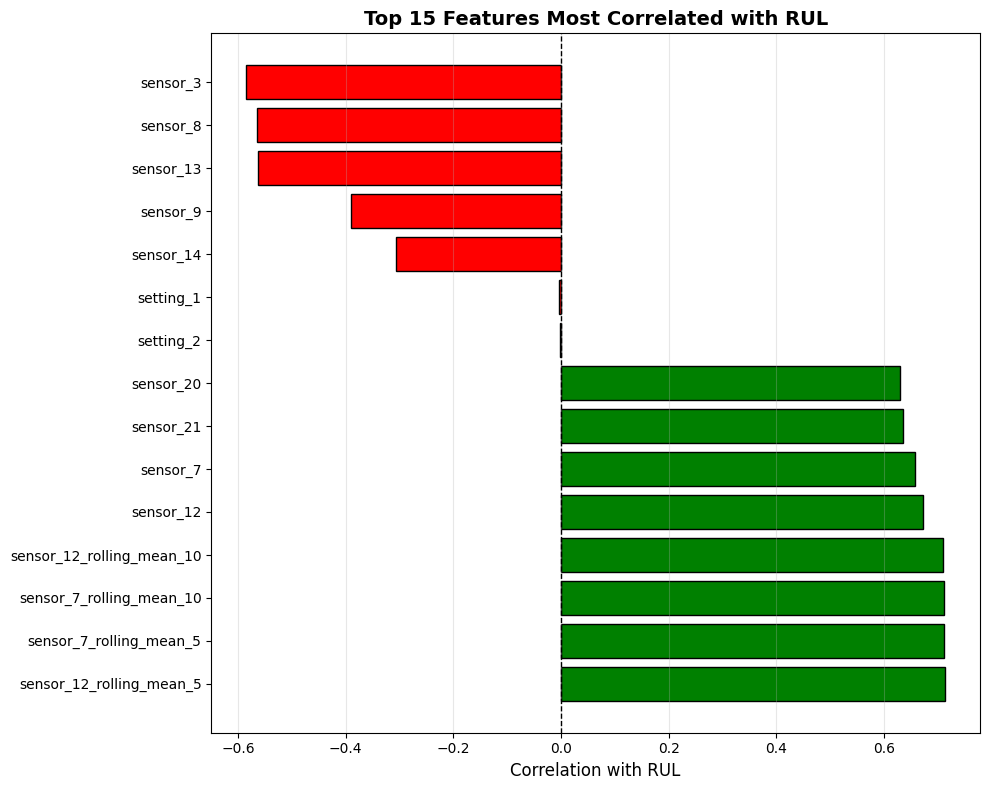


Preprocessing complete. Ready for model training.


In [9]:
print("-"*60)
print("DATA PREPROCESSING SUMMARY")
print("-"*60)

print("\nFEATURE BREAKDOWN:")
print(f"  - Settings: 3 (operational conditions)")
print(f"  - Original sensors: 14 (after removing 7 low-variance)")
print(f"  - Rolling features: 14 (trend indicators)")
print(f"  - Total features: {len(feature_columns)}")

print("\nTARGET VARIABLE:")
print(f"  - RUL (Remaining Useful Life)")
print(f"  - Range: 0 to {y.max()} cycles")
print(f"  - Mean: {y.mean():.1f} cycles")

print("\nDATASET SIZES:")
print(f"  - Training: {len(X_train):,} samples")
print(f"  - Testing: {len(X_test):,} samples")
print(f"  - Total: {len(X):,} samples")

# Visualize feature correlations with RUL
plt.figure(figsize=(10, 8))

# Calculate correlations with RUL
correlations = train_df[feature_columns + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

# Plot top 15 correlations
top_15 = correlations.head(15)
colors = ['green' if x > 0 else 'red' for x in top_15.values]

plt.barh(range(len(top_15)), top_15.values, color=colors, edgecolor='black')
plt.yticks(range(len(top_15)), top_15.index)
plt.xlabel('Correlation with RUL', fontsize=12)
plt.title('Top 15 Features Most Correlated with RUL', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPreprocessing complete. Ready for model training.")